<a href="https://colab.research.google.com/github/PritishWadhwa/DL-Assignments/blob/master/Assignment2/Ques1/CNN_dlAssignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/dlAssignments/Assignment2/

/content/drive/MyDrive/dlAssignments/Assignment2


In [3]:
ls

CNN_dlAssignment.ipynb  data@


In [72]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
plt.style.use('seaborn')
import os
import pathlib
import torch
from torchvision import datasets, transforms
import helper
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from collections import Counter
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [28]:
device

device(type='cuda')

In [5]:
# folders = os.listdir("data")
# folders

In [6]:
# path = pathlib.Path('data')
# dirs = path.glob("*")
# imageData = []
# labels = []
# count = {}
# labelDict = {
#     'Parasitized': 0,
#     'Uninfected': 1
# }
# for folder in tqdm(dirs):
#     c = 0
#     label = str(folder).split('/')[-1]
#     count[label] = 0
#     for imgPath in (folder.glob('*.png')):
#         # print(imgPath)
#         c += 1
#         print(c)
#         image = cv2.imread(str(imgPath))
#         count[label] += 1
#         imageData.append(image)
#         labels.append(labelDict[label])
#         # plt.imshow(image)
#         # plt.show()
#         # break

In [8]:
dataset = ImageFolder('./data',transform = transforms.Compose([
    transforms.Resize((150,150)),transforms.ToTensor()
]))

In [9]:
img, label = dataset[-1]
print(img.shape,label)

torch.Size([3, 150, 150]) 1


In [10]:
dataset.classes

['Parasitized', 'Uninfected']

In [14]:
len(dataset)

27558

In [16]:
trainSize = int(0.8*len(dataset))
valSize = (len(dataset) - trainSize)//2
testSize = len(dataset) - trainSize - valSize

In [48]:
trainData, valData, testData = random_split(dataset, [trainSize, valSize, testSize])

In [46]:
type(dataset), type(trainData)

(torchvision.datasets.folder.ImageFolder, torch.utils.data.dataset.Subset)

In [59]:
trainClasses = [dataset.targets[i] for i in (trainData.indices)]
print('train', Counter(trainClasses))
testClasses = [dataset.targets[i] for i in (testData.indices)]
print('test', Counter(testClasses))
valClasses = [dataset.targets[i] for i in (valData.indices)]
print('val', Counter(valClasses))

train Counter({0: 11065, 1: 10981})
test Counter({1: 1412, 0: 1344})
val Counter({1: 1386, 0: 1370})


In [60]:
len(trainData), len(valData), len(testData)

(22046, 2756, 2756)

In [62]:
trainDataLoader = DataLoader(trainData, 128, shuffle = True, num_workers = 2, pin_memory = True)
testDataLoader = DataLoader(testData, 128, shuffle = True, num_workers = 2, pin_memory = True)
valDataLoader = DataLoader(valData, 128, shuffle = True, num_workers = 2, pin_memory = True)

In [70]:
def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in (dl):
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break

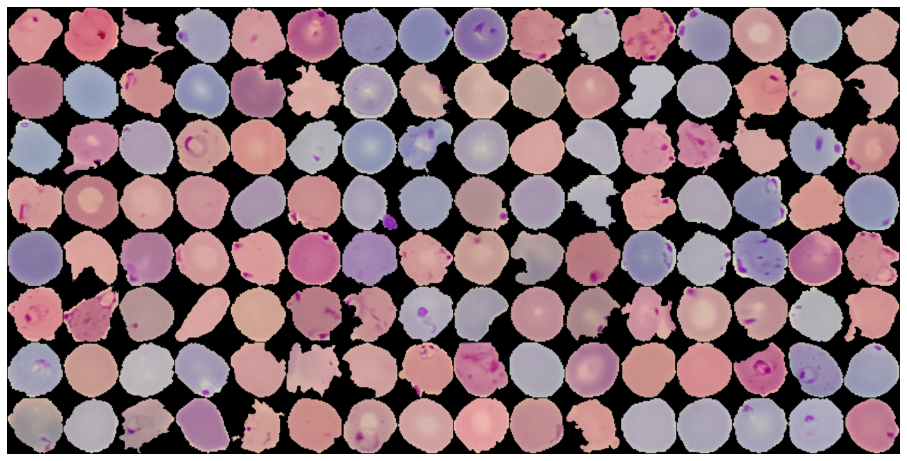

In [71]:
show_batch(trainDataLoader)

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.blockA = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=9)
        self.blockB = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=6)
        self.blockC = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3)
        self.maxPool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(150*150, 100)

In [31]:
testLabels = 0
for i in tqdm(testData):
    testLabels += i[1]
testLabels

  2%|▏         | 47/2756 [00:11<11:05,  4.07it/s]


KeyboardInterrupt: ignored

In [26]:
trainLabels = 0
valLabels = 0
testLabels = 0
for i in tqdm(trainData):
    trainLabels += i[1]
for i in valData:
    valLabels += i[1]
for i in testData:
    testLabels += i[1]
trainLabels, valLabels, testLabels

 17%|█▋        | 3793/22046 [17:16<1:23:06,  3.66it/s]


KeyboardInterrupt: ignored

In [33]:
trainLoader = DataLoader(trainData, batch_size=1, num_workers=0, shuffle=True)

In [35]:
trainLabels = 0
for step, (x, y) in tqdm(enumerate(trainLoader)):
    trainLabels += y

50it [00:14,  3.49it/s]


KeyboardInterrupt: ignored

In [ ]:
def display_img(img,label):
    print(f"Label : {dataset.classes[label]}")
    plt.imshow(img.permute(1,2,0))

Label : Uninfected


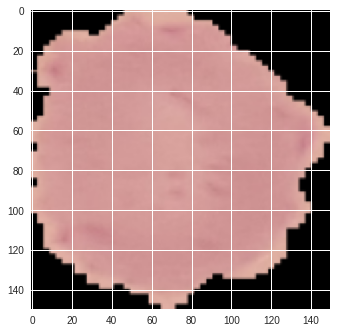

In [ ]:
display_img(*dataset[-1])

In [ ]:
cv2.imread('data/Parasitized/C91P52ThinF_IMG_20150821_125256_cell_4.png')

array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[162, 177, 216],
        [161, 178, 217],
        [161, 178, 217],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]

In [ ]:
transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()])
# transform = transforms.Compose([transforms.Resize(255),transforms.ToTensor()])

In [ ]:
dataset = datasets.ImageFolder('data', transform=transform)

In [ ]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
def imshow(image, ax=None, title=None, normalize=True):
  """Imshow for Tensor."""
  if ax is None:
      fig, ax = plt.subplots()
  image = image.numpy().transpose((1, 2, 0))

  if normalize:
      mean = np.array([0.485, 0.456, 0.406])
      std = np.array([0.229, 0.224, 0.225])
      image = std * image + mean
      image = np.clip(image, 0, 1)

  ax.imshow(image)
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  ax.tick_params(axis='both', length=0)
  ax.set_xticklabels('')
  ax.set_yticklabels('')

  return ax

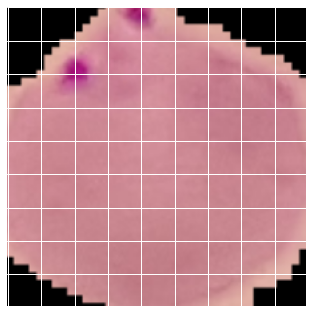

In [ ]:
images, labels = next(iter(dataloader))
imshow(images[0], normalize=False)

In [ ]:
helper.imshow(dataset[0], normalize=False)


AttributeError: ignored

In [ ]:
cd data

/content/drive/.shortcut-targets-by-id/15bq-XlNJT4oXrmSycUNcRCO-SG71cV-g/data
